# 📘 Spline Regression

## 📖 What Is Spline Regression?

**Spline regression** is a flexible approach to modeling nonlinear relationships by dividing the input space into intervals and fitting **piecewise polynomials**. These pieces are joined at **knots**, ensuring smoothness at those points.

---

### 🔧 Types of Splines

- **Piecewise Polynomials**: Polynomials in different regions, not necessarily smooth at boundaries.
- **Splines**: Piecewise polynomials **constrained to be smooth** at the knots.
- **Cubic Splines**: Most common — 3rd-degree polynomials joined with continuity of 1st and 2nd derivatives.
- **Natural Splines**: Cubic splines with additional constraint of linearity beyond boundary knots (for stability).

---

### 📐 Mathematical Form

Given knots $ \xi_1, \xi_2, \dots, \xi_K $, a cubic spline basis includes:

$$
1, x, x^2, x^3, (x - \xi_1)^3_+, \dots, (x - \xi_K)^3_+
$$

Where $ (x - \xi)^3_+ = (x - \xi)^3 $ if $ x > \xi $, 0 otherwise.

---

### ✅ When to Use Splines?

- When data is **smooth but nonlinear**
- To avoid high-degree polynomial overfitting
- When interpretability or local flexibility is needed




## Simulated data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrix
from sklearn.linear_model import LinearRegression
sns.set(style='whitegrid')

# Simulated data
np.random.seed(1)
X = np.sort(np.random.rand(100))
y = np.sin(2 * np.pi * X) + np.random.normal(0, 0.2, size=100)

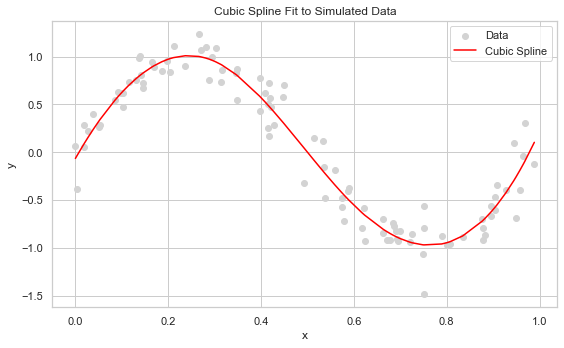

In [2]:
# Cubic spline basis using patsy
X_spline = dmatrix("bs(x, knots=(0.3, 0.6), degree=3, include_intercept=False)", {"x": X})
model = LinearRegression().fit(X_spline, y)
y_pred = model.predict(X_spline)

plt.figure(figsize=(8, 5))
plt.scatter(X, y, facecolor='lightgray', label='Data')
plt.plot(X, y_pred, color='red', label='Cubic Spline')
plt.title("Cubic Spline Fit to Simulated Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

## 🏠 Real Data: California Housing (Spline on Median Income)

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

data = fetch_california_housing()
X_real = data.data[:, 0]  # MedInc
y_real = data.target
X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.2, random_state=0)

In [4]:
# Build spline basis on training set
from patsy import dmatrix
X_train_spline = dmatrix("bs(x, df=6, degree=3, include_intercept=False)", {"x": X_train})
X_test_spline = dmatrix("bs(x, df=6, degree=3, include_intercept=False)", {"x": X_test})

model = LinearRegression().fit(X_train_spline, y_train)
y_pred = model.predict(X_test_spline)

print("R^2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R^2: 0.45936312130966805
MSE: 0.7049661083404176


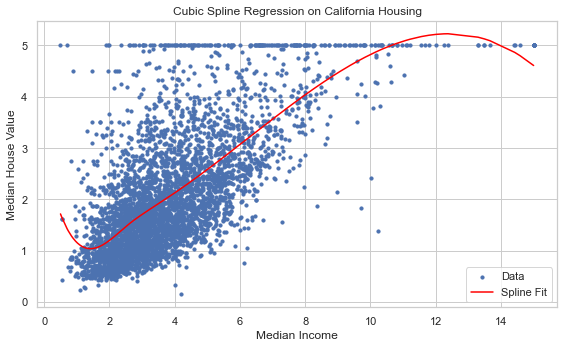

In [5]:
# Plot predictions on sorted test set
sort_idx = np.argsort(X_test)
X_sorted = X_test[sort_idx]
y_sorted = y_test[sort_idx]
y_sorted_pred = y_pred[sort_idx]

plt.figure(figsize=(8, 5))
plt.scatter(X_sorted, y_sorted, s=10, label='Data')
plt.plot(X_sorted, y_sorted_pred, color='red', label='Spline Fit')
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.title("Cubic Spline Regression on California Housing")
plt.legend()
plt.tight_layout()
plt.show()

Multivariate Spline Regression:
  MSE: 0.4357
  R^2: 0.6658


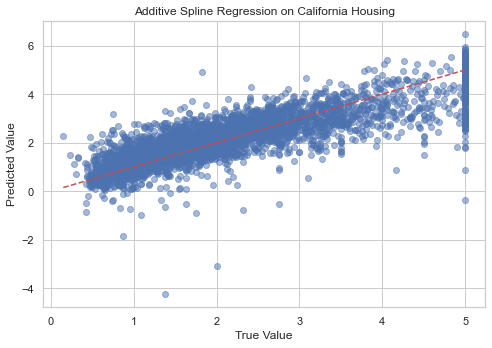

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from patsy import dmatrix

# Load data
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Build spline basis for each feature and concatenate them
def build_spline_df(df, degree=3, df_spline=6):
    spline_terms = []
    for col in df.columns:
        term = dmatrix(f"bs(x, df={df_spline}, degree={degree}, include_intercept=False)",
                       {"x": df[col]}, return_type='dataframe')
        term.columns = [f"{col}_spline_{i}" for i in range(term.shape[1])]
        spline_terms.append(term.reset_index(drop=True))
    return pd.concat(spline_terms, axis=1)

X_train_spline = build_spline_df(X_train)
X_test_spline = build_spline_df(X_test)

# Fit model
model = LinearRegression().fit(X_train_spline, y_train)
y_pred = model.predict(X_test_spline)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Multivariate Spline Regression:\n  MSE: {mse:.4f}\n  R^2: {r2:.4f}")

# Plot predicted vs true
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.title("Additive Spline Regression on California Housing")
plt.tight_layout()
plt.show()
